In [1]:
testing

NameError: name 'testing' is not defined

# Reanalysis: Hospital Readmissions and Recommendations for Reduction

### Background

This report is a reanalysis of the preliminary hospital readmissions recommendations. Although the initial report included some interesting insights, in this report I will aim to clarify and expand upon those observations.

In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
from statsmodels.stats import weightstats as stests
from scipy.stats import ttest_1samp
import seaborn as sns
import math
sns.set()
np.set_printoptions(formatter={'float': lambda x: '%.3f' % x})

In [2]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('data/cms_hospital_readmissions.csv')

In [3]:
hospital_read_df.head()

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,FROEDTERT MEMORIAL LUTHERAN HOSPITAL,520177,WI,READM-30-HIP-KNEE-HRRP,242,NaN,1.9095,10.8,5.6,38.0,07/01/2010,06/30/2013
1,PROVIDENCE HOSPITAL,90006,DC,READM-30-HIP-KNEE-HRRP,247,NaN,1.7521,9.2,5.3,33.0,07/01/2010,06/30/2013
2,BEAUFORT COUNTY MEMORIAL HOSPITAL,420067,SC,READM-30-HIP-KNEE-HRRP,586,NaN,1.5836,7.6,4.8,53.0,07/01/2010,06/30/2013
3,ADVOCATE CHRIST HOSPITAL & MEDICAL CENTER,140208,IL,READM-30-HIP-KNEE-HRRP,965,NaN,1.5760,9.0,5.7,95.0,07/01/2010,06/30/2013
4,BRAZOSPORT REGIONAL HEALTH SYSTEM,450072,TX,READM-30-HIP-KNEE-HRRP,149,NaN,1.5308,8.2,5.4,20.0,07/01/2010,06/30/2013


****
## Preliminary Analysis

In [4]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')
clean_hospital_read_df[-5:]


/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
8126,NAPLES COMMUNITY HOSPITAL,100018,FL,READM-30-HIP-KNEE-HRRP,2716,NaN,0.9804,5.2,5.3,141.0,07/01/2010,06/30/2013
6643,COMMUNITY MEDICAL CENTER,310041,NJ,READM-30-COPD-HRRP,2740,NaN,1.0003,22.7,22.7,623.0,07/01/2010,06/30/2013
1892,FLORIDA HOSPITAL,100007,FL,READM-30-HF-HRRP,3570,NaN,1.0896,24.5,22.5,879.0,07/01/2010,06/30/2013
13615,NEW ENGLAND BAPTIST HOSPITAL,220088,MA,READM-30-HIP-KNEE-HRRP,3980,NaN,0.7682,3.7,4.8,142.0,07/01/2010,06/30/2013
13666,HOSPITAL FOR SPECIAL SURGERY,330270,NY,READM-30-HIP-KNEE-HRRP,6793,NaN,0.7379,3.9,5.3,258.0,07/01/2010,06/30/2013


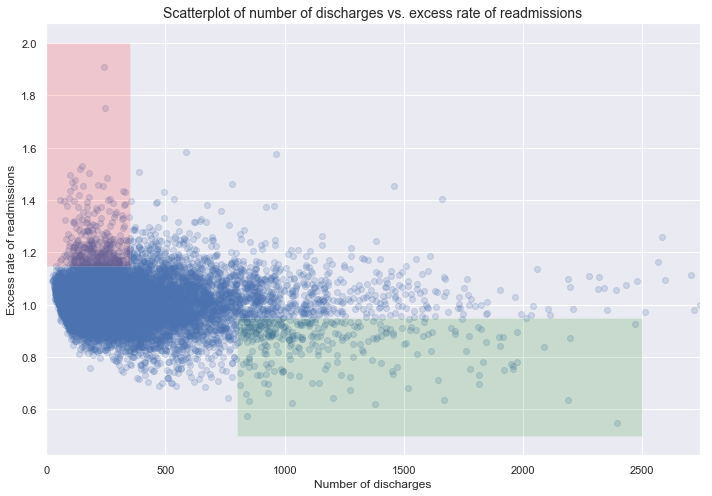

In [5]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])
x = list(clean_hospital_read_df['Number of Discharges'][81:-3])

fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

_______

## Secondary Report, A Reanalysis

### Dissecting the Preliminary Report

#### Excess Readmissions Ratio

To start, it should be pointed out that there is information missing about the way the hospital "predicted" readmissions were determined. Since, the excess readmissions are at the heart of this report, it is a crucial piece of information that is missing from this analysis.

#### Initial Observations

* It would of been helpful if the graph above included a line of best fit so the reader could visually determine that there is downward trend to readmissions and number of discharges. See the first graph listed below to have a better visualization of the slope of the line.

* Referring to the graph above, there is undeniably something happening with the red shaded area (lower number of discharges/greater rate of readmissions). 

* When looking at the same scatter plot as above without the green shaded area and a line at 1.0, one can see there seems to be a fairly even number of >1.0 readmissions as there are < 1.0 readmissions for hospitals with a large number of discharges (see second listed graph below). Thus, more investigation is needed for the claim that the hospitals with large discharge numbers also have a lower readmission rates.

#### Statistics

* A proper hypothesis test needs to be performed to see if the difference in the small versus large hospitals is due to chance, or if it is statistically significant

#### Conclusions & Recommendations

* It is correct to say there is a correlation between hospital capacity and readmission rates; however a classification model needs to be investigated here to see what other factors are contributing to the readmission rates.

* It is a leap to say small hospitals need to upgrade their resource allocations from the information provided in the above analysis, and an even big leap to propose consolidation of hospitals. 

### Steps for Reanalysis

1. Set up a hypothesis test analyzing the claim the proportions of readmissions are statistically significant using **bootstrap two-sample test** and **frequentist two-sample test**

2. Consider different types of graphical representations for the above data


/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


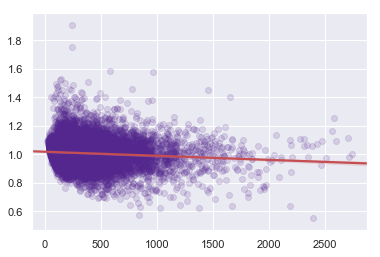

In [6]:
#Graph showing line of best fit
sns.regplot(x, y, data = clean_hospital_read_df, color= "#54278f", scatter_kws={'alpha':0.15}, line_kws={'color':'r'})
plt.show()

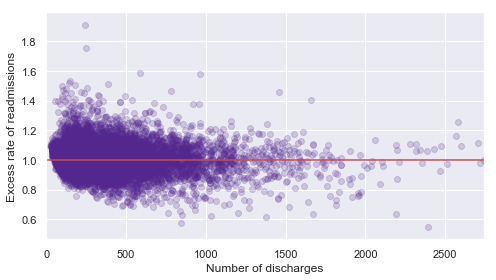

In [7]:
#Graph showing line at 1.0 readmissions with no shaded areas

fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(x, y,alpha=0.2, color = "#54278f")
ax.set_xlim([0, max(x)])
plt.axhline(1.0, color='r')
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.grid(True)
fig.tight_layout()

_______

### 1. Hypothesis Testing 
#### Stating the Hypothesis & Alpha:
* Null hypothesis 
>$H_0: \mu1 = \mu2 $
>*There is no difference between excess readmission means in large and small hospitals*

* Alternative hypothesis 
> $ H_1: \mu1 > \mu2 $
>*Small hospitals have a larger readmission mean than large hospitals*

* Significance Level
> $ {\alpha = .01} $

#### Splitting up the large versus small hospital data frames:

In [8]:
small_h = clean_hospital_read_df[clean_hospital_read_df['Number of Discharges'] <100][81:-3]
medium_h = clean_hospital_read_df[(clean_hospital_read_df['Number of Discharges'] >100) & (clean_hospital_read_df['Number of Discharges'] <= 1000)][81:-3]
large_h = clean_hospital_read_df[clean_hospital_read_df['Number of Discharges'] >1000][81:-3]

#### Verfying proportions and averages:

In [9]:
#Average excess readmission ratio
large_mean = np.mean(large_h["Excess Readmission Ratio"])
small_mean = np.mean(small_h["Excess Readmission Ratio"])
print (f"Large Hospital mean: {large_mean:.3f}")
print (f"Small Hospital mean: {small_mean:.3f}")

Large Hospital mean: 0.982
Small Hospital mean: 1.023


In [10]:
#Calculating percents above 1.0
s_readmission_ratio = small_h[small_h["Excess Readmission Ratio"]> 1.0]
s_percent_above= len(s_readmission_ratio) / len(small_h)

l_readmission_ratio = large_h[large_h["Excess Readmission Ratio"]> 1.0]
l_percent_above= len(l_readmission_ratio) / len(large_h)

print (f"Large Hospital Proportion above 1.0 Readmission: {l_percent_above}")
print (f"Small Hospital Proportion above 1.0 Readmission: {s_percent_above}")

Large Hospital Proportion above 1.0 Readmission: 0.45910290237467016
Small Hospital Proportion above 1.0 Readmission: 0.6320675105485232


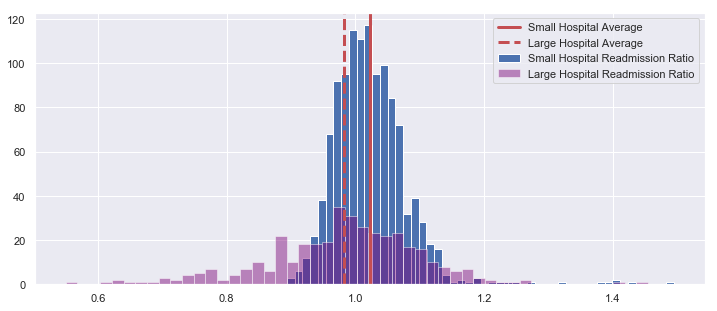

In [11]:
fig, ax = plt.subplots(figsize=(12,5))
plt.hist(small_h["Excess Readmission Ratio"], bins=50,color= "b", label='Small Hospital Readmission Ratio')
plt.hist(large_h["Excess Readmission Ratio"], bins=50, alpha=0.45, color= "#7a0177", label='Large Hospital Readmission Ratio')
plt.axvline(1.023, color='r', label="Small Hospital Average", linewidth= 3)
plt.axvline(0.982, color='r', label="Large Hospital Average", linestyle= "dashed", linewidth= 3)
plt.legend(loc='upper right')
plt.show()

#### 2-Sample Bootstrap Test

In [12]:
#Bootstrap Function

#MAIN function:takes in a number of samples plus data & Function
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates

#function to convert data to a sample
def bootstrap_replicate_1d(data,func):
    """Generate bootstrap replicate of 1d data"""
    bs_sample= np.random.choice(data, len(data))
    return func(bs_sample)

In [13]:
#Concatenate the large & small df's together, calculate their combined mean, and turn both columns into arrays

#concatenating the two subsetted data frames
combined_df= pd.concat([small_h, large_h])

#computing the combined mean
combined_mean= np.mean(combined_df["Excess Readmission Ratio"])
print (f"Combined mean: {combined_mean}")

#turning into arrays for functions
small_h_array = small_h["Excess Readmission Ratio"].values
large_h_array = large_h["Excess Readmission Ratio"].values


Combined mean: 1.0127508312020457


In [14]:
#Applying the bootstrap test

#Compute the original difference of means:
original_diff_mean = np.mean(small_mean-large_mean)

# Shift each array so they reflect the combined mean
s_shifted = small_h_array - small_mean + combined_mean 
l_shifted = large_h_array - large_mean + combined_mean 

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_s = draw_bs_reps(s_shifted, np.mean, 10000)
bs_replicates_l = draw_bs_reps(l_shifted, np.mean, 10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_s - bs_replicates_l

# Compute and print p-value: p
p = np.sum(bs_replicates >= original_diff_mean) / len(bs_replicates) 

print ("Bootstrap Test Results")
print(f'P-value = {p:.5f}')
if p < 0.01:    # alpha value is 0.01 or 1%
    print("We reject the null hypothesis")
else:
    print("We accept the null hypothesis")

#create a bootstrap test for the combined data to compute the confidence interval
bs_replicates_all = draw_bs_reps(combined_df["Excess Readmission Ratio"],np.mean, size=10000)

# Compute the 99% confidence interval: conf_int
conf_int = np.percentile(bs_replicates_all, [.05, 99.5])

# Print the confidence interval & margin of error
print(f"The margin of error = {combined_mean - conf_int[:1]}")
print(f'The 99% confidence interval = {conf_int}')

Bootstrap Test Results
P-value = 0.00000
We reject the null hypothesis
The margin of error = [0.007]
The 99% confidence interval = [1.006 1.018]


#### Frequentist Two-Sample Hypothesis Test

In [15]:
#code for a frequentist/traditional two sample hypothesis test

#z-test 
ztest ,pval = stests.ztest(small_h_array, x2=large_h_array, value=0)

print("Frequentist Two-Sample Test Results")
#results
print(f"P-value:{pval:.5f}")
if pval < 0.01:    # alpha value is 0.01 or 1%
    print("We reject the null hypothesis")
else:
    print("We accept the null hypothesis")
    
# Compute mean and standard deviation of the current sample: mu, sigma
n= len(combined_df["Excess Readmission Ratio"])
sd = np.std(combined_df["Excess Readmission Ratio"])
z= 2.575 #critical z-value for 99% confidence interval

#Compute the 95% confidence interval
margin_er = z * (sd/math.sqrt(n))

# Print the confidence interval & margin of error
print(f"The margin of error = {margin_er}")
print(f'The 99% confidence interval = [{combined_mean- margin_er}, {combined_mean + margin_er}]')

Frequentist Two-Sample Test Results
P-value:0.00000
We reject the null hypothesis
The margin of error = 0.00519533535212249
The 99% confidence interval = [1.007555495849923, 1.0179461665541683]


#### Hypothesis Test Conclusions
Both the bootstrap and the frequentist test confirm that we can reject the null hypothesis that the large and small hospital readmission ratio averages are the same. There is in fact a statistically significant difference between the two. However, just because the difference is validated, does not mean the discrepancy between the number of discharges is the reason why. There could be many other important factors contributing to this, and further classification models need to be explored before giving concrete recommendations. 

_____

### 2. Exploring Different Graphs
#### Analyzing the first graph

The original scatter plot shown in the preliminary analysis is a good start because it clearly shows a relationship between the number of discharges and the Excess Readmission Ratio. However, there are a couple drawbacks with this method:

* The reader cannot visually interpret the difference between small and large hospitals * * The density of the scatter points is impossible to visualize. 

#### Other Graphs to Explore: 

*I believe a big missing component is to visually see the difference between small, medium, and large hospitals*

1. Joint plot comparing small ,medium, & large hospitals
2. Violin plot comparing small, medium, & large hospitals
3. Density heat map

In [16]:
#setting the x and y coordinates with lists because they work better
x_s = list(small_h['Number of Discharges'])
y_s = list(small_h['Excess Readmission Ratio'])
x_m = list(medium_h['Number of Discharges'])
y_m = list(medium_h['Excess Readmission Ratio'])
x_l = list(large_h['Number of Discharges'])
y_l = list(large_h['Excess Readmission Ratio'])

#### 1. Joint Plots
* With the three graphs below you can see the difference in the lines of best fit and correlation coefficients
* The preliminary analysis was correct that the small hospitals do in fact improve their readmission rate when their number of discharges increase
* You can also view the outliers of the small hospitals more clearly. This was initially recognized in the preliminary scatter plot with the "red area".
* There is a clear distinction that small hospitals perform worst on the rate of readmission, the medium hospitals perform the next best with an average hovering close to 1.0, and the large hospitals perform the best with an average under 1.0
* However, this is other contributing factors need to be investigated further before making a policy prescription

Small Hospital Pearson Correlation:-0.24486621646964712
Small Hospital Mean:1.0226365400843886


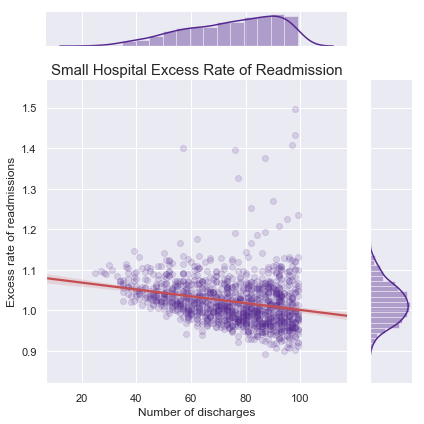

In [17]:
#Small Hospitals
sns.jointplot(x_s, y_s, data = small_h, kind= "reg", space=.2, color= "#54278f", scatter_kws={'alpha':0.15}, line_kws={'color':'r'})
plt.xlabel('Number of discharges', fontsize=12)
plt.ylabel('Excess rate of readmissions', fontsize=12)
plt.title("Small Hospital Excess Rate of Readmission", fontsize=15)
plt.tight_layout()
small_h_r = stats.pearsonr(x_s, y_s)
print(f"Small Hospital Pearson Correlation:{small_h_r[0]}")
print(f"Small Hospital Mean:{small_mean}")

Medium Hospital Pearson Correlation:-0.05715922457742587
Medium Hospital Mean:1.0071747404132827


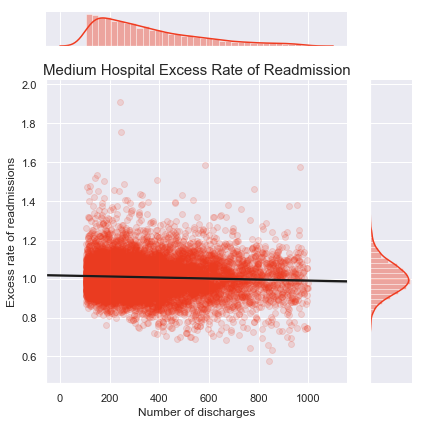

In [18]:
#Medium hospitals
sns.jointplot(x_m, y_m, data = medium_h, kind= "reg", space=.2, color= "#f03b20", scatter_kws={'alpha':0.15},line_kws={'color':'k'})
plt.xlabel('Number of discharges', fontsize=12)
plt.ylabel('Excess rate of readmissions', fontsize=12)
plt.title("Medium Hospital Excess Rate of Readmission", fontsize=15)
plt.tight_layout()
medium_h_r = stats.pearsonr(x_m, y_m)
print(f"Medium Hospital Pearson Correlation:{medium_h_r[0]}")
print(f"Medium Hospital Mean:{np.mean(y_m)}")

Large Hospital Pearson Correlation:-0.05042898206535658
Large Hospital Mean:0.9818416886543535


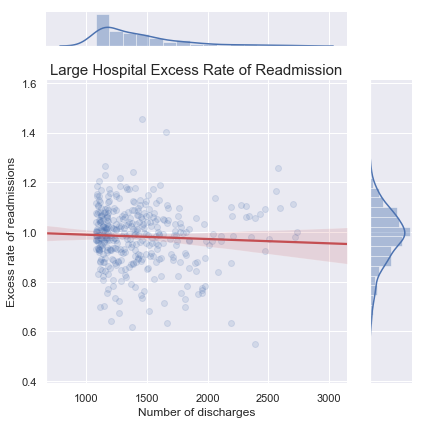

In [19]:
#large hospitals
sns.jointplot(x_l, y_l, data = large_h, kind= "reg", space=.2,scatter_kws={'alpha':0.15},line_kws={'color':'r'})
plt.xlabel('Number of discharges', fontsize=12)
plt.ylabel('Excess rate of readmissions', fontsize=12)
plt.title("Large Hospital Excess Rate of Readmission", fontsize=15)
plt.tight_layout()
large_h_r = stats.pearsonr(x_l, y_l)
print(f"Large Hospital Pearson Correlation:{large_h_r[0]}")
print(f"Large Hospital Mean:{large_mean}")

#### 2. Violin Plot
* The plots below display surprising results that the small, medium, and large hospitals all have around the same inner quartile ranges, and are all basically normally skewed (which was also apparent in the joint plot histograms)
* However, The small and medium hospitals have a lot of outliers (denoted by the long extending lines) which might be skewing their results
* Large hospitals also have an interesting distribution right below the 1.2 mark


<function matplotlib.pyplot.show(*args, **kw)>

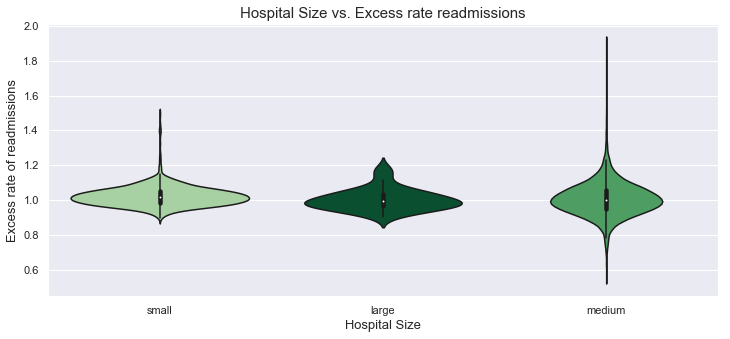

In [20]:
#First, create a function to classify hospital between small, medium, or large based on discharge numbers

def sizes(x):
    if x < 100:
        return "small"
    elif x > 100 & x <=1000:
        return "medium"
    else:
        return "large"

#create a new column in the data frame with sizes
clean_hospital_read_df["Size"]= [sizes(row) for row in clean_hospital_read_df["Number of Discharges"]]

#Creating a color palette
my_pal = {"small": "#a1d99b", "medium": "#41ab5d", "large": "#005a32"}

#Generate Plot
fig, ax = plt.subplots(figsize=(12,5))
sns.violinplot(x="Size", y="Excess Readmission Ratio", data = clean_hospital_read_df, palette=my_pal)
plt.title("Hospital Size vs. Excess rate readmissions", fontsize=15)
plt.xlabel("Hospital Size", fontsize= 13)
plt.ylabel("Excess rate of readmissions", fontsize= 13)
plt.show

#### 3. Density Heat Map
*This could be good to pair with the original scatter plot to see the density of the points, but would not be good on it's own*

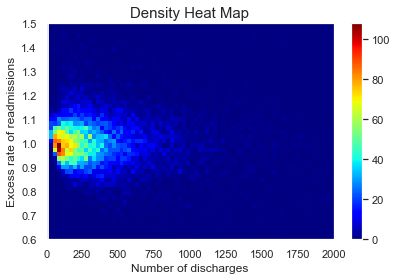

In [21]:
plt.hist2d(x, y, bins=(100, 75), cmap=plt.cm.jet)
plt.xlim([0, 2000])
plt.ylim([.6,1.5])
plt.xlabel('Number of discharges', fontsize=12)
plt.ylabel('Excess rate of readmissions', fontsize=12)
plt.title("Density Heat Map",fontsize=15)
plt.tight_layout()
plt.colorbar()
plt.show()

### Secondary Prescriptions

After conducting a secondary analysis of the preliminary results, there are three future things to consider:

1. Build a classification model to investigate the differences of other factors in small, medium, and large hospitals readmission rates to see if you can narrow down a concrete reason
2. Although close, The large hospitals did perform the best so look into why this is happening
3. Study the outliers of the small and the medium hospitals and compare against the inner quartile range to see what these outliers are doing better or worse at. 